In [1]:
!pip install -q scikit-learn
!pip install -q scikit-image
!pip install -q opencv-python
!pip install -q matplotlib

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# Enter the directory, filename, and extension of the input file

print("Please enter the following details for the input file:")
directory = input("Enter the directory: ")
filename = input("Enter the filename: ")
file_extension = input("Enter the file extension: ")

Please enter the following details for the input file:


Enter the directory:  ~/Desktop/Segmentation
Enter the filename:  example
Enter the file extension:  .jpg


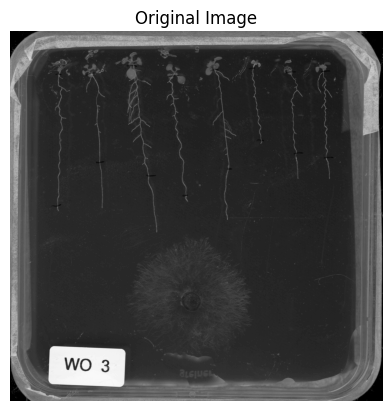

In [4]:
# Read the image and convert it to grayscale
directory = os.path.expanduser(directory)
file_path = os.path.join(directory, filename + file_extension)

# Read the image
img = cv2.imread(file_path)

if img is not None:
    # Convert image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Display the image
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Unable to load image from path {file_path}")

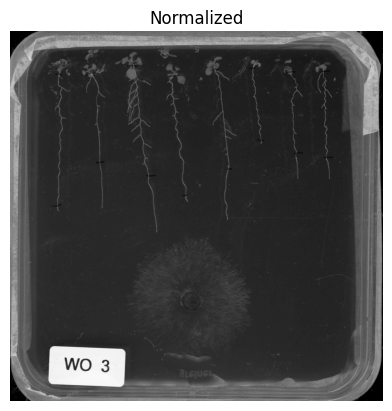

In [5]:
# Normalize the image for zero mean and unit variance
mean = np.mean(img)
std = np.std(img)
normalized_img = (img - mean) / std

# Display the image
plt.imshow(normalized_img, cmap='gray')
plt.title('Normalized')
plt.axis('off')
plt.show()

Select a slice of the image that contains the roots, including the root tips.
Please enter the slice parameters as percentages of the image's total size:


What percentage from the top should the slice start? (0-100):  20
What percentage from the top should the slice end? (0-100):  55
What percentage from the left should the slice start? (0-100):  10
What percentage from the left should the slice end? (0-100):  90


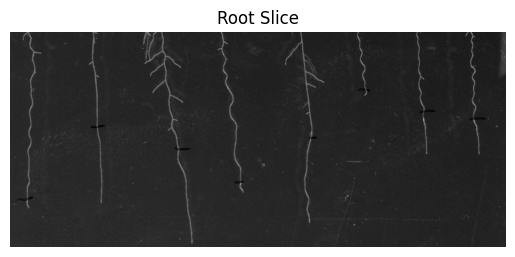

In [6]:
# Select a slice of the image containing the roots, which will be used for noise reduction and clustering

# Function to convert percentage input to pixel value
def percentage_to_pixel(percentage, total):
    return int((percentage / 100) * total)

# Prompt user for slice parameters
print("Select a slice of the image that contains the roots, including the root tips.")
print("Please enter the slice parameters as percentages of the image's total size:")

row_start_percent = float(input("What percentage from the top should the slice start? (0-100): "))
row_end_percent = float(input("What percentage from the top should the slice end? (0-100): "))
col_start_percent = float(input("What percentage from the left should the slice start? (0-100): "))
col_end_percent = float(input("What percentage from the left should the slice end? (0-100): "))

# Extract the number of rows and columns in the image
row_size, col_size = normalized_img.shape[:2]

# Convert percentages to pixel values
row_start = percentage_to_pixel(row_start_percent, row_size)
row_end = percentage_to_pixel(row_end_percent, row_size)
col_start = percentage_to_pixel(col_start_percent, col_size)
col_end = percentage_to_pixel(col_end_percent, col_size)

# Extract the slice
root_slice = normalized_img[row_start:row_end, col_start:col_end]

# Display the slice
plt.imshow(root_slice, cmap='gray')
plt.title('Root Slice')
plt.axis('off')
plt.show()

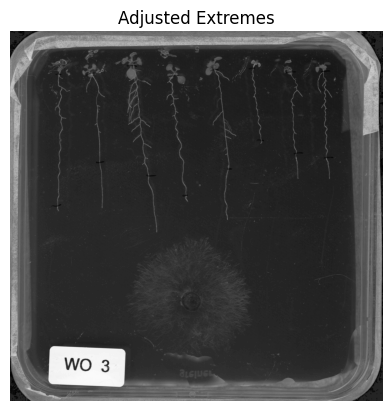

In [7]:
# Replace the minimum and maximum pixel values of the entire image with the mean pixel value of the root slice
# This mitigates the effect of extreme pixel values/outliers

# Calculate the mean of the pixel values in the slice containing roots
mean = np.mean(root_slice)

# Find the maximum and minimum pixel values in the entire image
max = np.max(normalized_img)
min = np.min(normalized_img)

# Replace maximum and minimum pixel values in the entire image with the calculated mean
normalized_img[normalized_img == max] = mean
normalized_img[normalized_img == min] = mean

# Display the image
plt.imshow(normalized_img, cmap='gray')
plt.title('Adjusted Extremes')
plt.axis('off')
plt.show()

In [8]:
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure

Please specify the size of the kernel for morphological erosion.


Enter the number of square pixels:  3


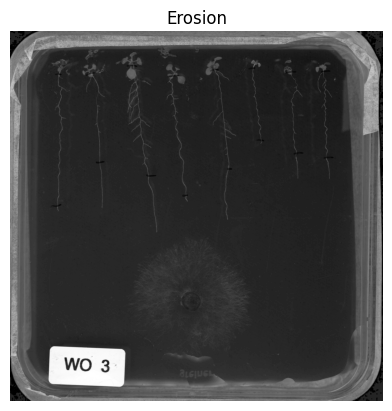

In [9]:
# Apply erosion, which shrinks bright regions and reduces dark regions, for noise reduction
# Suggested kernel size: 3 square pixels

# Define the erosion kernel size
print("Please specify the size of the kernel for morphological erosion.")
erosion_kernel = int(input("Enter the number of square pixels: "))

eroded = morphology.erosion(normalized_img, np.ones([erosion_kernel, erosion_kernel]))

# Display the image
plt.imshow(eroded, cmap='gray')
plt.title('Erosion')
plt.axis('off')
plt.show()

Please specify the size of the kernel for morphological dilation.


Enter the number of square pixels:  10


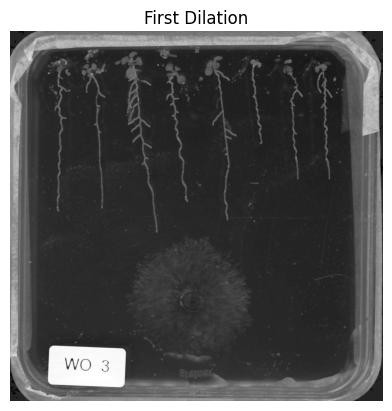

In [10]:
# Apply dilation, which expands bright regions and shrinks dark regions
# This can be used to restore object size after noise reduction or to enlarge regions of interest
# Suggested kernel size: 10 square pixels, to enlarge the root regions

# Define the dilation kernel size
print("Please specify the size of the kernel for morphological dilation.")
dilation_kernel = int(input("Enter the number of square pixels: "))

dilated = morphology.dilation(eroded, np.ones([dilation_kernel, dilation_kernel]))

# Display the image
plt.imshow(dilated, cmap='gray')
plt.title('First Dilation')
plt.axis('off')
plt.show()

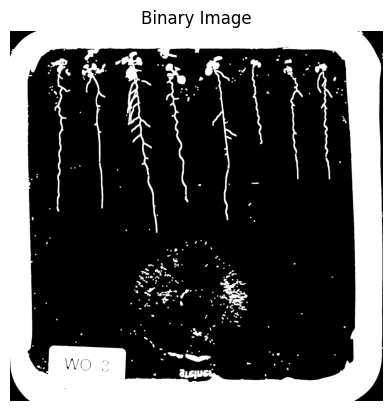

In [11]:
# Apply K-means clustering to identify two clusters in the image based on pixel intensities
# The mean of the cluster centers is then used as a threshold to create a binary thresholded image

# Reshape the root slice into a 2D array of pixel intensities for K-means
pixels_reshaped = np.reshape(root_slice, [np.prod(root_slice.shape), 1])

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, n_init=10).fit(pixels_reshaped)
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)

# Set pixels below the threshold to 0 and those above to i
binary_img = np.where(dilated < threshold, 0.0, 1.0)

# Display the image
plt.imshow(binary_img, cmap='gray')
plt.title('Binary Image')
plt.axis('off')
plt.show()

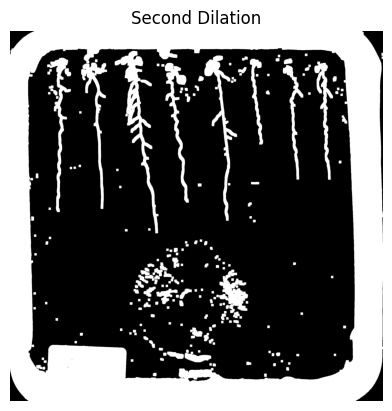

In [12]:
# Perform dilation on the binary image
dilated_binary = morphology.dilation(binary_img,np.ones([10,10]))

# Display the image
plt.imshow(dilated_binary, cmap='gray')
plt.title('Second Dilation')
plt.axis('off')
plt.show()

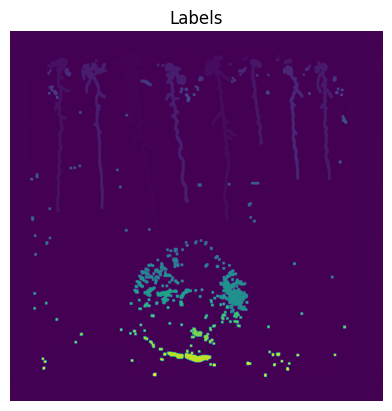

In [13]:
# Assign unique labels to connected regions
labels = measure.label(dilated_binary)

# Display the image
plt.imshow(labels)
plt.title('Labels')
plt.axis('off')
plt.show()

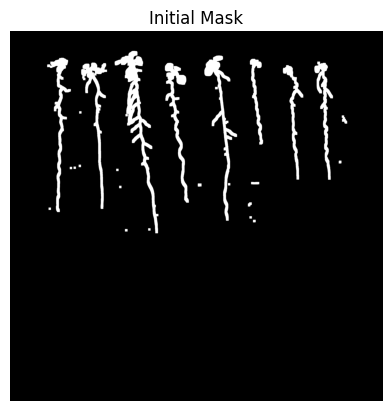

In [14]:
# Create an initial mask only including regions that intersect with the slice containing roots

# Select regions that intersect with the slice
regions = measure.regionprops(labels)
intersecting_regions = []

for region in regions:
    B = region.bbox
    if B[0] < row_end and B[2] > row_start and B[1] < col_end and B[3] > col_start:
        if B[0] != 0 and B[1] != 0 and B[2] != col_size: # Excluding regions that touch the borders
            intersecting_regions.append(region.label)
            
# Create a mask using the identified regions        
initial_mask = np.zeros_like(labels)
for i in intersecting_regions:
    initial_mask = np.where(labels == i, 1, initial_mask)

# Display the image
plt.imshow(initial_mask, cmap='gray')
plt.title('Initial Mask')
plt.axis('off')
plt.show()

In [15]:
def select_regions_by_id(input_mask):
    """
    This function performs connected component analysis on an input binary mask to identify distinct regions.
    After displaying the regions, it prompts the user to enter the IDs of the regions they wish to keep.

    Based on the user's selection, the function creates and returns a final mask. This mask includes only 
    the user-selected regions, setting pixels belonging to these regions to True (1) and all other pixels 
    to False (0).

    Parameters:
    input_mask (numpy array): A binary mask where the regions of interest are marked.

    Returns:
    final_mask (numpy array): A binary mask that includes only the regions selected by the user.
    """
    
    # Perform connected component analysis
    labeled_image = measure.label(input_mask)
    regions = measure.regionprops(labeled_image)

    # Display each region with a unique color and label
    plt.figure(figsize=(10, 6))
    plt.imshow(labeled_image, cmap='nipy_spectral')
    for region in regions:
        y, x = region.centroid
        plt.text(x, y, str(region.label), color='white', ha='center', va='center')

    plt.colorbar()
    plt.title("Regions with Unique IDs")
    plt.show()

    # List IDs of the top 10 regions with the largest areas
    sorted_regions = sorted(regions, key=lambda x: x.area, reverse=True)
    top_regions = sorted_regions[:10]
    print("Top 10 regions by area:")
    for region in top_regions:
        print(f"ID: {region.label}, Area: {region.area}")

    # Ask user to select which regions to include
    selected_ids = input("Enter the IDs of the regions to keep (comma-separated): ")
    selected_ids = [int(id.strip()) for id in selected_ids.split(',')]

    # Create final mask with the selected regions
    final_mask = np.zeros_like(input_mask, dtype=bool)
    for region_id in selected_ids:
        final_mask[labeled_image == region_id] = True

    return final_mask

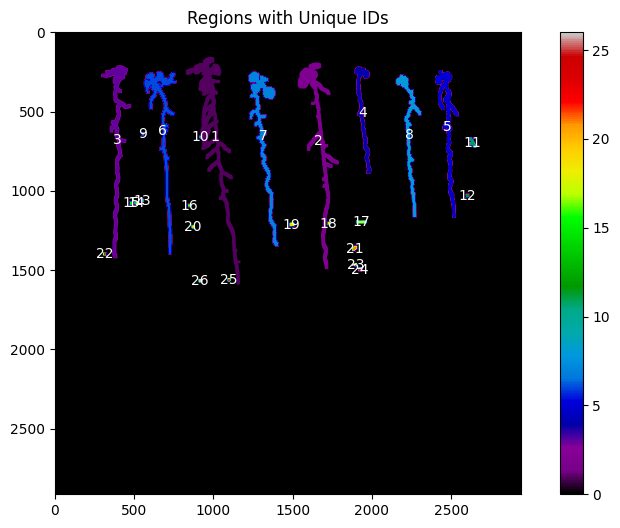

Top 10 regions by area:
ID: 1, Area: 86696.0
ID: 2, Area: 55278.0
ID: 6, Area: 46926.0
ID: 7, Area: 46859.0
ID: 3, Area: 44168.0
ID: 5, Area: 36412.0
ID: 8, Area: 28551.0
ID: 4, Area: 21005.0
ID: 11, Area: 1666.0
ID: 17, Area: 1264.0


Enter the IDs of the regions to keep (comma-separated):  1,2,6,7,3,5,8,4


In [16]:
# Select the regions to include in the final mask
final_mask = select_regions_by_id(initial_mask)

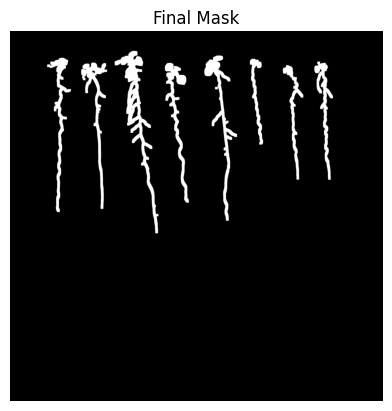

In [17]:
# Display the final mask
plt.imshow(final_mask, cmap='gray')
plt.title('Final Mask')
plt.axis('off')
plt.show()

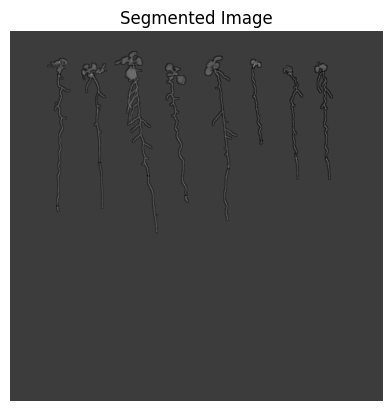

In [18]:
# Create and display the segmented image
seg_img = final_mask * normalized_img

plt.imshow(seg_img, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')
plt.show()

In [19]:
from skimage.io import imsave

In [20]:
# Save the final mask

print("Please enter the following details to save the final mask:")

mask_output_directory = input("Enter the output directory: ")
mask_output_directory = os.path.expanduser(mask_output_directory)

os.makedirs(mask_output_directory, exist_ok=True)
mask_file_path = os.path.join(mask_output_directory, filename + "_mask.png")

imsave(mask_file_path, final_mask)

print(f"Image saved as '{mask_file_path}'")

Please enter the following details to save the final mask:


Enter the output directory:  ~/Desktop/Segmentation


/var/folders/2g/bw5x8b_n5ndfcbhw904w41780000gn/T/ipykernel_57841/4253186676.py:11: UserWarning: /Users/jackie/Desktop/Segmentation/example_mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(mask_file_path, final_mask)


Image saved as '/Users/jackie/Desktop/Segmentation/example_mask.png'


In [21]:
# Save the segmented image

print("Please enter the following details to save the segmented image:")

seg_output_directory = input("Enter the output directory: ")
seg_output_directory = os.path.expanduser(seg_output_directory)
seg_file_extension = input("Enter the file extension: ")

os.makedirs(seg_output_directory, exist_ok=True)
seg_file_path = os.path.join(seg_output_directory, filename + "_seg" + seg_file_extension)

seg_img_uint8 = (seg_img * 255).astype('uint8')
imsave(seg_file_path, seg_img_uint8)

print(f"Image saved as '{seg_file_path}'")

Please enter the following details to save the segmented image:


Enter the output directory:  ~/Desktop/Segmentation
Enter the file extension:  .jpg


Image saved as '/Users/jackie/Desktop/Segmentation/example_seg.jpg'
